[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/moon_oed/blob/main/00_e_0_oed_mdn.ipynb)

In [1]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/moon_oed tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        ! head -4 requirements.txt > tmp.txt
        ! mv tmp.txt requirements.txt 
        ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

If you are working in Google Colab you can change the instance from 'CPU' to a GPU of your choice. This will speed up the training process.

In [2]:
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch

from zuko.distributions import Joint, Truncated, Uniform, Normal, Independent

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

In [3]:
import pandas as pd

kernel_df = pd.read_csv('data/sensitivity_kernels/sensitivity_kernels.csv')
freqs = kernel_df.keys()

velocity_model = pd.read_csv('data/velocity_model_no_ice.csv')
depths = torch.tensor(velocity_model['depth'].values)
vp_model = torch.tensor(velocity_model['vp'].values)
vs_model = torch.tensor(velocity_model['vs'].values)

velocity_model_ice = pd.read_csv('data/velocity_model_ice.csv')
vp_model_ice = torch.tensor(velocity_model_ice['vp'].values)
vs_model_ice = torch.tensor(velocity_model_ice['vs'].values)

vp_homogeneous = vp_model[:5].mean().item()
vp_ice_homogeneous = vp_model_ice[:5].mean().item()

print('vp_homogeneous:', vp_homogeneous)
print('vp_ice_homogeneous:', vp_ice_homogeneous)

vp_homogeneous: 108.0
vp_ice_homogeneous: 332.0


## Setup

In [4]:
length_x = 500
length_y = 500

N_rec = 10

## Construct True Model

In [5]:
true_model_mean = torch.tensor(
    [[300, 230]])
true_model_std = torch.tensor(
    [[40, 60]])
true_model_amp = torch.tensor(
    [vp_ice_homogeneous+10])
true_model_theta = torch.tensor(
    [0.3*torch.pi])

true_model = torch.hstack([
    true_model_mean, true_model_std,
    true_model_amp.unsqueeze(-1),
    true_model_theta.unsqueeze(-1)]).squeeze(0)

## Forward Model and Data Likelihood

In [6]:
from helpers.forward import ForwardModelHomogeneous, DataLikelihoodHomogeneous

data_noise = 0.2

forward_model = ForwardModelHomogeneous(vp_homogeneous)
data_likelihood = DataLikelihoodHomogeneous(forward_model, data_noise)

## Prior Distribution

In [7]:
coordinate_prior = Independent(
    Truncated(
        Normal(torch.tensor([250.0, 250.0]), torch.tensor([200.0, 200.0])),
        lower=0.0, upper=length_x), 1)
std_prior = Independent(
    Truncated(
        Normal(torch.tensor([50.0, 50.0]), torch.tensor([30.0, 30.0])),
        lower=10.0, upper=100.0), 1)
amp_prior = Independent(Normal(torch.tensor([350.0]), 10.0),1)
theta_prior = Independent(Uniform(torch.tensor([0.0]), torch.tensor([0.5*torch.pi])), 1)

parameter_names = ['x', 'y', 'std_x', 'std_y', 'amp', 'theta']
prior_dist = Joint(coordinate_prior, std_prior, amp_prior, theta_prior)

# Run Optimal Design

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [9]:
# generate initial design
from torch.quasirandom import SobolEngine
sobol = SobolEngine(dimension=2, scramble=True, seed=19)

initial_design = sobol.draw(N_rec)
initial_design[:, 0] *= length_x
initial_design[:, 1] *= length_y

In [10]:
N_init = 1000

torch.manual_seed(0)

init_models = prior_dist.sample((N_init,))

init_data = torch.vstack([
    forward_model(init_models[i].unsqueeze(-2), initial_design) for i in range(0, N_init)],)

mean_design = initial_design.mean(dim=0, keepdim=True)
std_design = initial_design.std(dim=0, keepdim=True)

# Normalize edge features (train data)
mean_init_data = init_data.mean(dim=0, keepdim=True)
std_init_data = init_data.std(dim=0, keepdim=True)

mean_init_models = init_models.mean(dim=0, keepdim=True)
std_init_models = init_models.std(dim=0, keepdim=True)

Number of parameters in ConditionalGaussian: 151564


Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

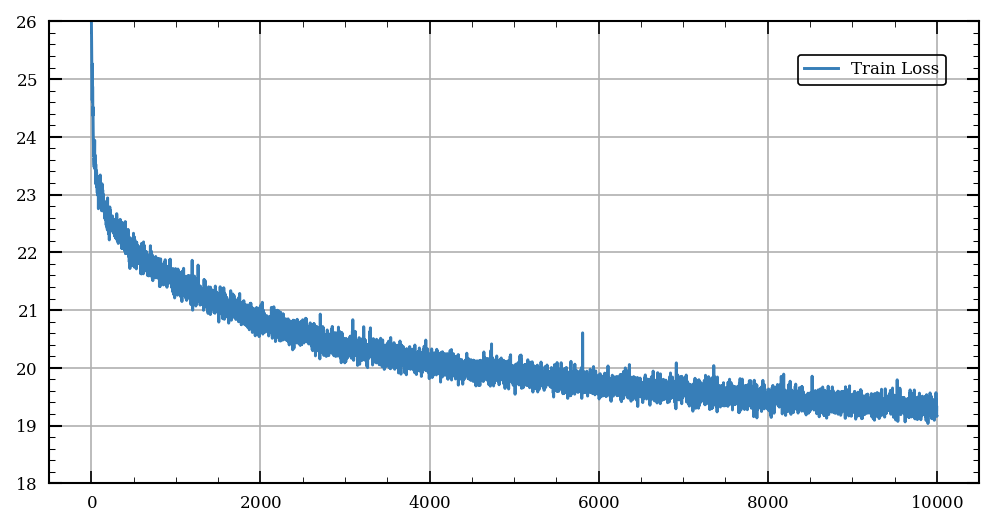

In [11]:
from helpers.variational import ConditionalGaussian

optimal_design = initial_design.detach().clone().to(device)
initial_design = initial_design.detach().clone()

optimal_design.requires_grad = True

conditional_gaussian = ConditionalGaussian(
    N_rec=N_rec,
    features=len(parameter_names),
    model_mean=mean_init_models,
    model_std=std_init_models,
    data_mean=mean_init_data,
    data_std=std_init_data,
    design_mean=mean_design,
    design_std=std_design,
    hidden_features=(256, 256, 256),
).to(device)

# Print the number of parameters
num_params = sum(p.numel() for p in conditional_gaussian.parameters() if p.requires_grad)
print(f'Number of parameters in ConditionalGaussian: {num_params}')

N_steps = 10000
N_batch = 1024


# filename = 'data/models/00_d_0_fixed_mdn_gpu.pth'}
filename = None

flow_optimizer = torch.optim.Adam(
    conditional_gaussian.parameters(), lr=1e-3)

design_optimizer = torch.optim.Adam(
    [optimal_design,], lr=mean_design.mean() * 1e-4)

design_path_list = []

if filename is not None and os.path.exists(filename):
    checkpoint = torch.load(filename)
    conditional_gaussian.load_state_dict(checkpoint['model_state_dict'])
    flow_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_list = checkpoint['loss_list']
else:
    loss_list = []

    for step in (pbar := tqdm(range(N_steps), desc='Epochs')):
        
        flow_optimizer.zero_grad()
        design_optimizer.zero_grad()
        
        model_i = prior_dist.sample((N_batch,)).to(device)
        data_i = data_likelihood(model_i, optimal_design).rsample()
                
        posterior = conditional_gaussian(data_i.to(device), optimal_design.unsqueeze(0).repeat(N_batch, 1, 1).to(device))
    
        loss = -posterior.log_prob(model_i.to(device)).mean()

        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            conditional_gaussian.parameters(), 1.0)

        flow_optimizer.step()

        if step > (N_steps//20):
            design_optimizer.step()

        # clip design to the domain
        optimal_design.data[:, 0].clamp_(0, length_x)
        optimal_design.data[:, 1].clamp_(0, length_y)

        loss_list.append(loss.item())
        
        pbar.set_postfix(loss_list=torch.tensor(loss_list[-100:]).mean().item())

        if step % 100 == 0:
            design_path_list.append(optimal_design.detach().cpu().clone())

    loss_list = torch.tensor(loss_list)

    # Save the model and optimizer state
    if filename is not None:
        torch.save({
            'model_state_dict': conditional_gaussian.state_dict(),
            'optimizer_state_dict': flow_optimizer.state_dict(),
            'loss_list': loss_list,
        }, filename)

design_path = torch.stack(design_path_list, dim=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(torch.linspace(0, N_steps, len(loss_list)), loss_list, label='Train Loss')

ax.set_ylim(18, 26)
ax.grid(True)

ax.legend()
plt.show()

In [12]:
conditional_gaussian.eval()
conditional_gaussian.to('cpu');

optimal_design = optimal_design.detach().cpu()

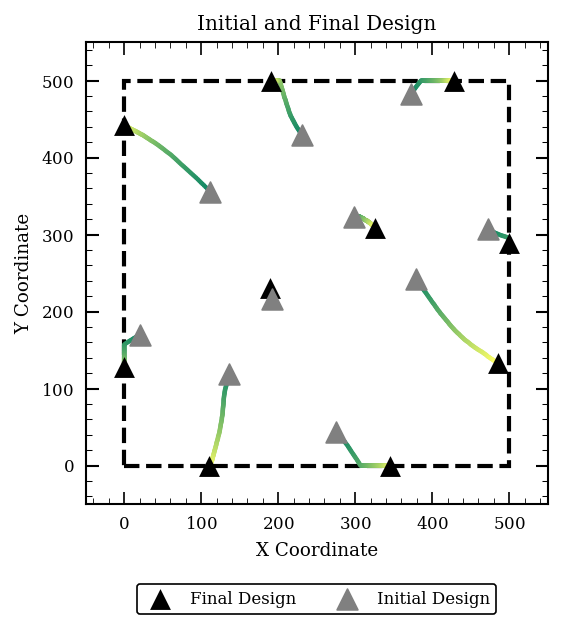

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

colors = plt.cm.summer(torch.linspace(0, 1, design_path.shape[1]))

for i, path in enumerate(design_path):
    ax.scatter(
        path[:, 0].detach().cpu().numpy(),
        path[:, 1].detach().cpu().numpy(),
        s=2, c=colors)
    
# Plot initial design
ax.scatter(optimal_design[:, 0].detach().cpu().numpy(),
           optimal_design[:, 1].detach().cpu().numpy(),
           marker='^', color='k', linewidths=0.0,
           s=100,
           label='Final Design', zorder=2)

# Plot final design
ax.scatter(initial_design[:, 0].detach().cpu().numpy(),
           initial_design[:, 1].detach().cpu().numpy(),
           s=100, marker='^', color='grey', label='Initial Design', zorder=2)

ax.set_aspect('equal')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Initial and Final Design')
# legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
# ax.grid(True)

buffer = 50
ax.set_xlim(0-buffer, length_x+buffer)
ax.set_ylim(0-buffer, length_y+buffer)

ax.add_patch(plt.Rectangle(
    (0, 0), length_x, length_y,
    fill=None, linestyle='dashed', color='black', linewidth=2, zorder=-10))
ax.set_aspect('equal')

plt.show()

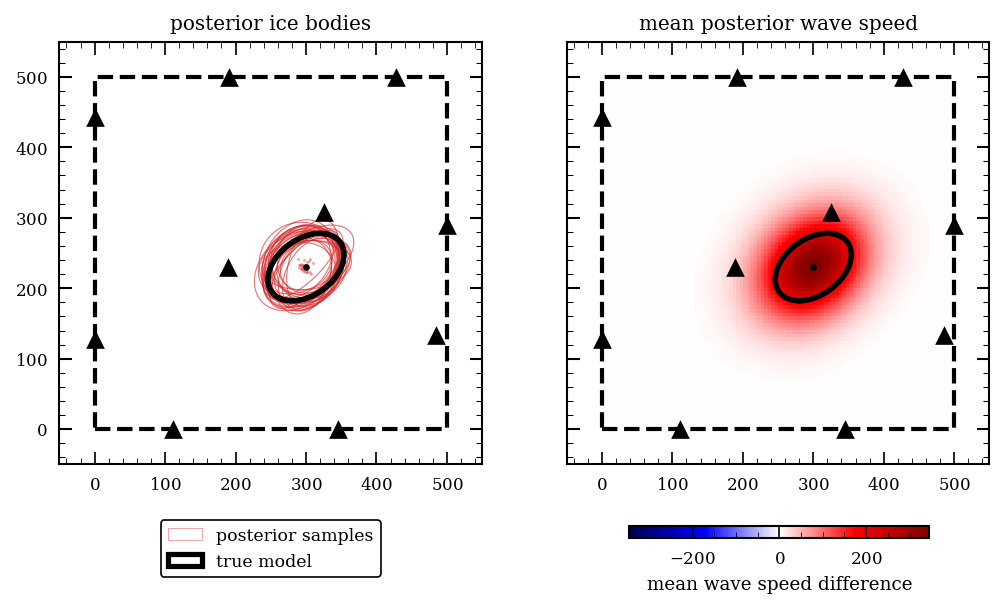

In [14]:
from helpers.plotting import (
    plot_n_posterior,
    plot_single_posterior
)


N_posterior_samples = 10000

observed_data = forward_model(
        true_model.unsqueeze(0), optimal_design.cpu()).squeeze(0)

posterior_samples = conditional_gaussian(
    observed_data.unsqueeze(0),
    optimal_design.unsqueeze(0)).sample((N_posterior_samples,)).squeeze(1)


plot_single_posterior(
    posterior_samples, true_model, optimal_design, length_x, length_y)

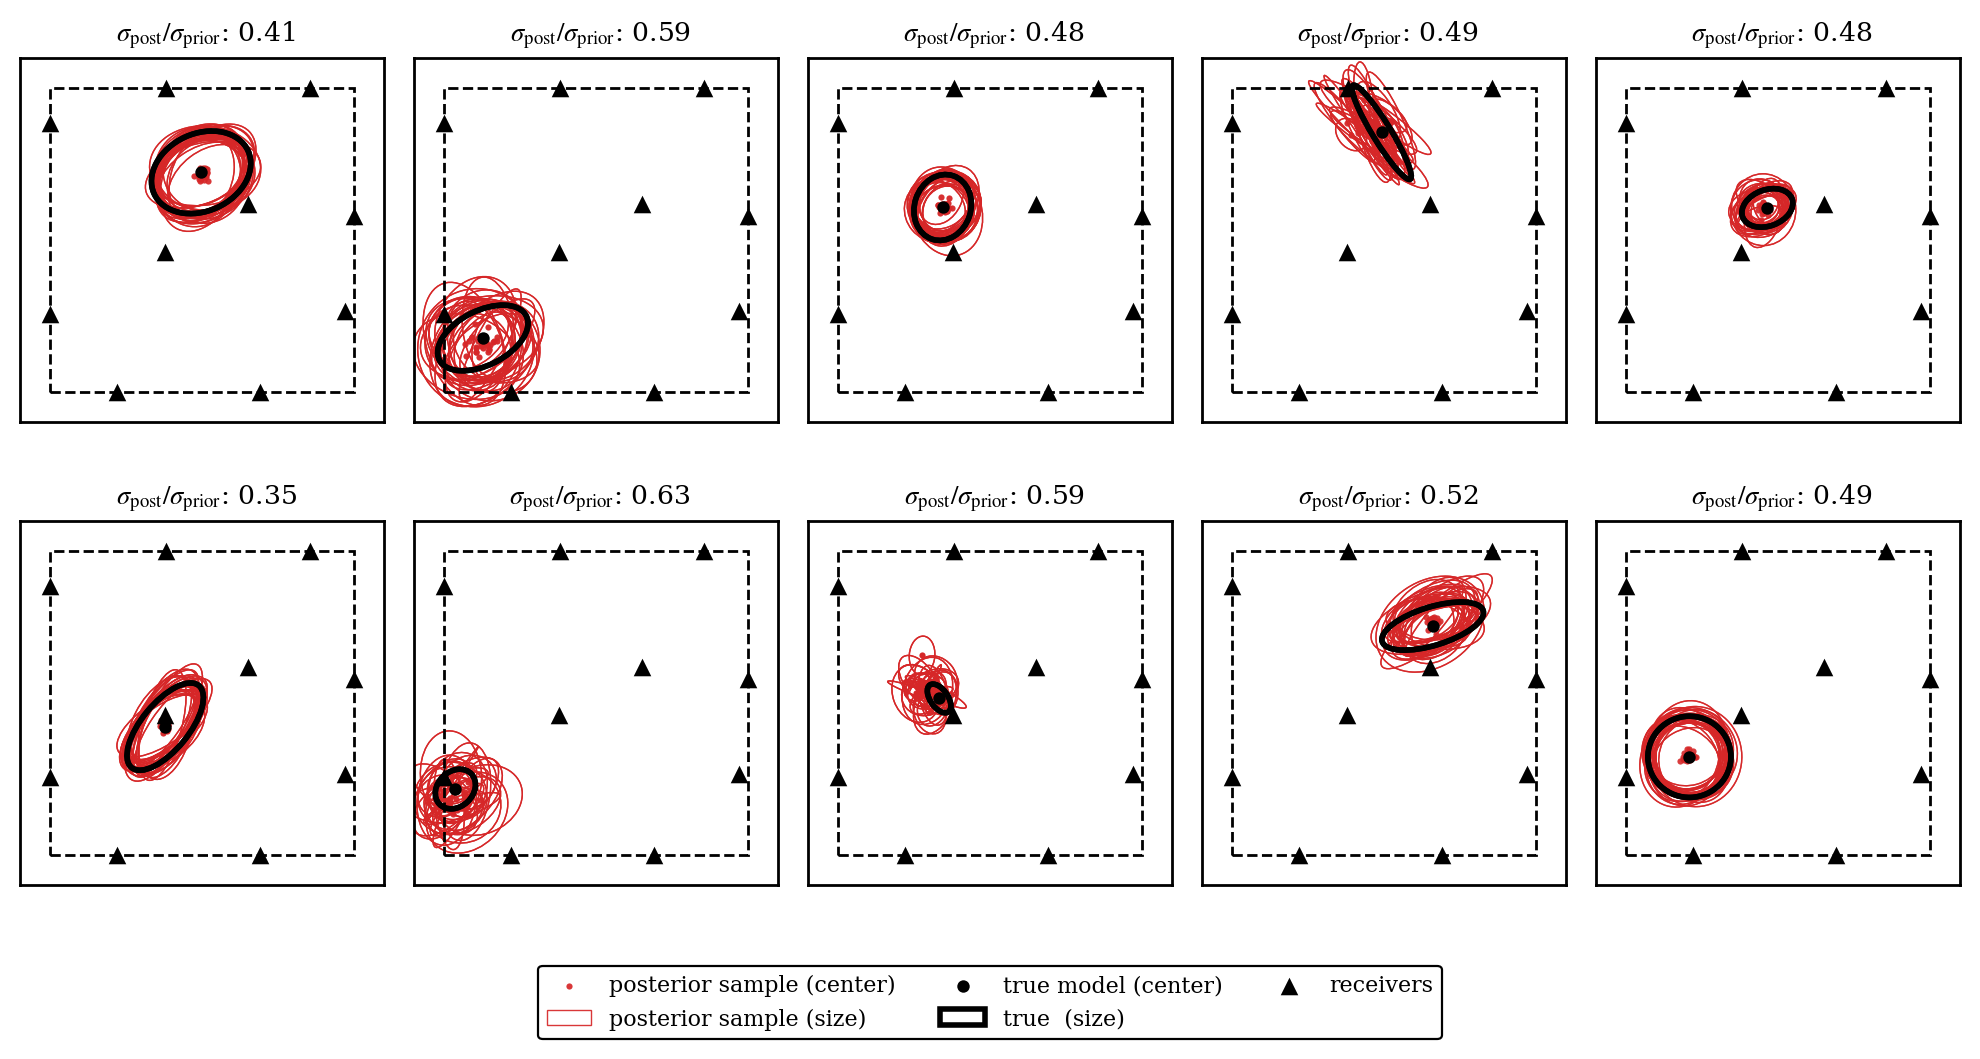

In [15]:
plot_n_posterior(
    prior_dist,
    forward_model,
    conditional_gaussian.cpu(),
    optimal_design.cpu().detach(),
    length_x, length_y,
    plot_mean=False,
    plot_samples=True)

## Construct True Model

In [16]:
true_model_mean = torch.tensor(
    [[300, 230]])
true_model_std = torch.tensor(
    [[40, 60]])
true_model_amp = torch.tensor(
    [vp_ice_homogeneous+10])
true_model_theta = torch.tensor(
    [0.3*torch.pi])

true_model = torch.hstack([
    true_model_mean, true_model_std,
    true_model_amp.unsqueeze(-1),
    true_model_theta.unsqueeze(-1)]).squeeze(0)

Updating the prior using observations at the optimal design

In [17]:
observed_data = forward_model(true_model.unsqueeze(0), optimal_design.cpu()).squeeze(0)

updated_prior = conditional_gaussian(
    observed_data.unsqueeze(0), optimal_design.unsqueeze(0).cpu())

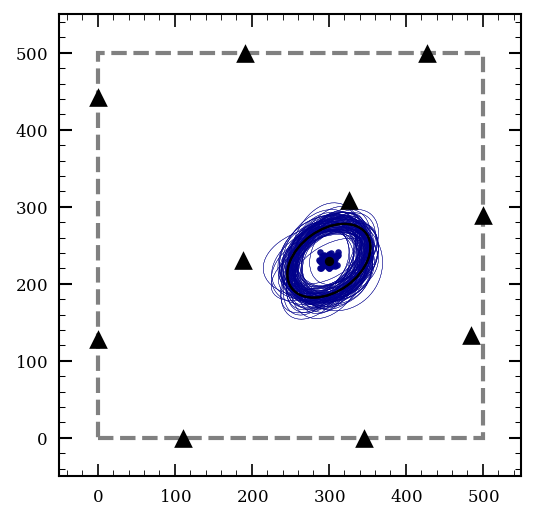

In [18]:
from helpers.plotting import plot_ellipses
# Plot the setup
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

updated_samples = updated_prior.sample((100,)).squeeze(1)

plot_ellipses(ax, updated_samples[:100, :2], updated_samples[:100, 2:4],
              updated_samples[:100, 5], updated_samples[:100, 4],
              scatter_kwargs={'c': 'darkblue', 's': 10},
              ellipse_kwargs={'edgecolor': 'darkblue', 'linewidth': 0.2})

# plot true model
plot_ellipses(
    ax, true_model_mean, true_model_std, true_model_theta, true_model_amp,
    scatter_kwargs={'c': 'k', 's': 20},
    ellipse_kwargs={'edgecolor': 'k', 'linewidth': 1.0})

ax.scatter(
    optimal_design.detach().cpu().numpy()[:, 0],
    optimal_design.detach().cpu().numpy()[:, 1],
    linewidths=0, 
    marker='^', color='k', s=80, zorder=2)

buffer=50

ax.set_xlim(0-buffer, length_x+buffer)
ax.set_ylim(0-buffer, length_y+buffer)
# draw rectangle
ax.add_patch(plt.Rectangle(
    (0, 0), length_x, length_y,
    fill=None, linestyle='dashed', color='grey', linewidth=2))

ax.set_aspect('equal')

plt.show()

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

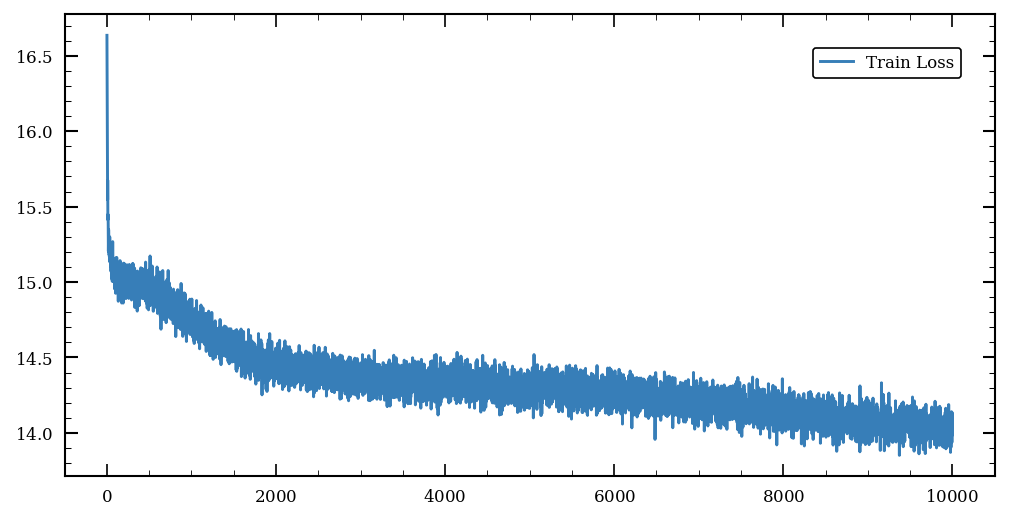

In [19]:
from copy import deepcopy

updated_design = optimal_design.detach().clone().to(device)
updated_design.requires_grad = True

updated_cond_gaussian = deepcopy(conditional_gaussian).to(device)

N_steps = 10000
N_batch = 1024

loss_list_updated = []

optimizer_updated = torch.optim.Adam(
    updated_cond_gaussian.parameters(), lr=1e-4)
design_optimizer_updated = torch.optim.Adam(
    [updated_design,], lr=mean_design.mean() * 1e-4)

design_path_list_updated = []

for step in (pbar := tqdm(range(N_steps), desc='Epochs')):
    
    optimizer_updated.zero_grad()
    design_optimizer_updated.zero_grad()
    
    model_i = updated_prior.sample((N_batch,)).squeeze(1).to(device)
        
    data_i = data_likelihood(model_i, updated_design).rsample()
            
    posterior = updated_cond_gaussian(data_i.to(device), updated_design.unsqueeze(0).repeat(N_batch, 1, 1).to(device))

    loss = -posterior.log_prob(model_i.to(device)).mean()

    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(
        updated_cond_gaussian.parameters(), 1.0)

    optimizer_updated.step()
    
    if step > (N_steps//20):
        design_optimizer_updated.step()
    
    # clip design to the domain
    updated_design.data[:, 0].clamp_(0, length_x)
    updated_design.data[:, 1].clamp_(0, length_y)
        
    loss_list_updated.append(loss.item())
    
    pbar.set_postfix(loss_list=torch.tensor(loss_list_updated[-100:]).mean().item())
    
    if step % 100 == 0:
        design_path_list_updated.append(updated_design.detach().cpu().clone())

loss_list_updated = torch.tensor(loss_list_updated)
design_path_updated = torch.stack(design_path_list_updated, dim=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(torch.linspace(0, N_steps, len(loss_list_updated)), loss_list_updated, label='Train Loss')

ax.legend()

plt.show()

In [20]:
updated_cond_gaussian.eval()
updated_cond_gaussian.to('cpu');

updated_design = updated_design.detach().cpu()

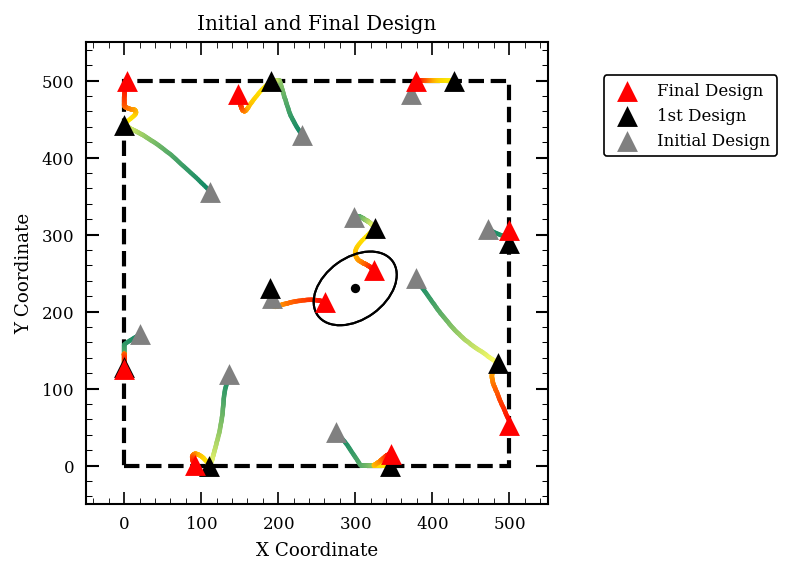

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

colors = plt.cm.summer(torch.linspace(0, 1, design_path.shape[1]))

for i, path in enumerate(design_path):
    ax.scatter(
        path[:, 0].detach().cpu().numpy(),
        path[:, 1].detach().cpu().numpy(),
        s=2, c=colors)
    
colors = plt.cm.autumn_r(torch.linspace(0, 1, design_path_updated.shape[1]))

for i, path in enumerate(design_path_updated):
    ax.scatter(
        path[:, 0].detach().cpu().numpy(),
        path[:, 1].detach().cpu().numpy(),
        s=2, c=colors)

ax.scatter(
    updated_design[:, 0].detach().cpu().numpy(),
    updated_design[:, 1].detach().cpu().numpy(),
    marker='^', color='red', linewidths=0.0,
    s=100, label='Final Design', zorder=3)

ax.scatter(
    optimal_design[:, 0].detach().cpu().numpy(),
    optimal_design[:, 1].detach().cpu().numpy(),
    marker='^', color='black', linewidths=0.0,
    s=100,label='1st Design', zorder=2)

ax.scatter(
    initial_design[:, 0].detach().cpu().numpy(),
    initial_design[:, 1].detach().cpu().numpy(),
    marker='^', color='grey', linewidths=0.0,
    s=100, label='Initial Design')

plot_ellipses(
    ax, true_model_mean, true_model_std, true_model_theta, true_model_amp,
    scatter_kwargs={'c': 'k', 's': 20},
    ellipse_kwargs={'edgecolor': 'k', 'linewidth': 1.0})

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Initial and Final Design')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

buffer = 50
ax.set_xlim(0-buffer, length_x+buffer)
ax.set_ylim(0-buffer, length_y+buffer)

ax.add_patch(plt.Rectangle(
    (0, 0), length_x, length_y,
    fill=None, linestyle='dashed', color='black', linewidth=2, zorder=-10))
ax.set_aspect('equal')

plt.show()

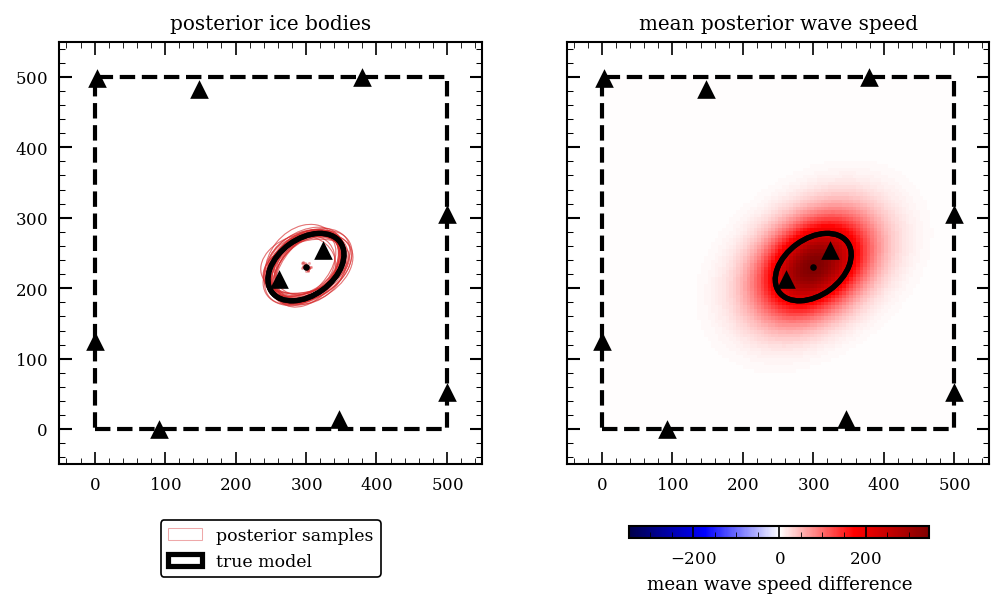

In [22]:
N_posterior_samples = 10000

updated_observed_data = forward_model(
        true_model.unsqueeze(0), updated_design.cpu()).squeeze(0)

posterior_samples = updated_cond_gaussian(
    updated_observed_data.unsqueeze(0),
    updated_design.unsqueeze(0)).sample((N_posterior_samples,)).squeeze(1)

plot_single_posterior(
    posterior_samples, true_model, updated_design, length_x, length_y)

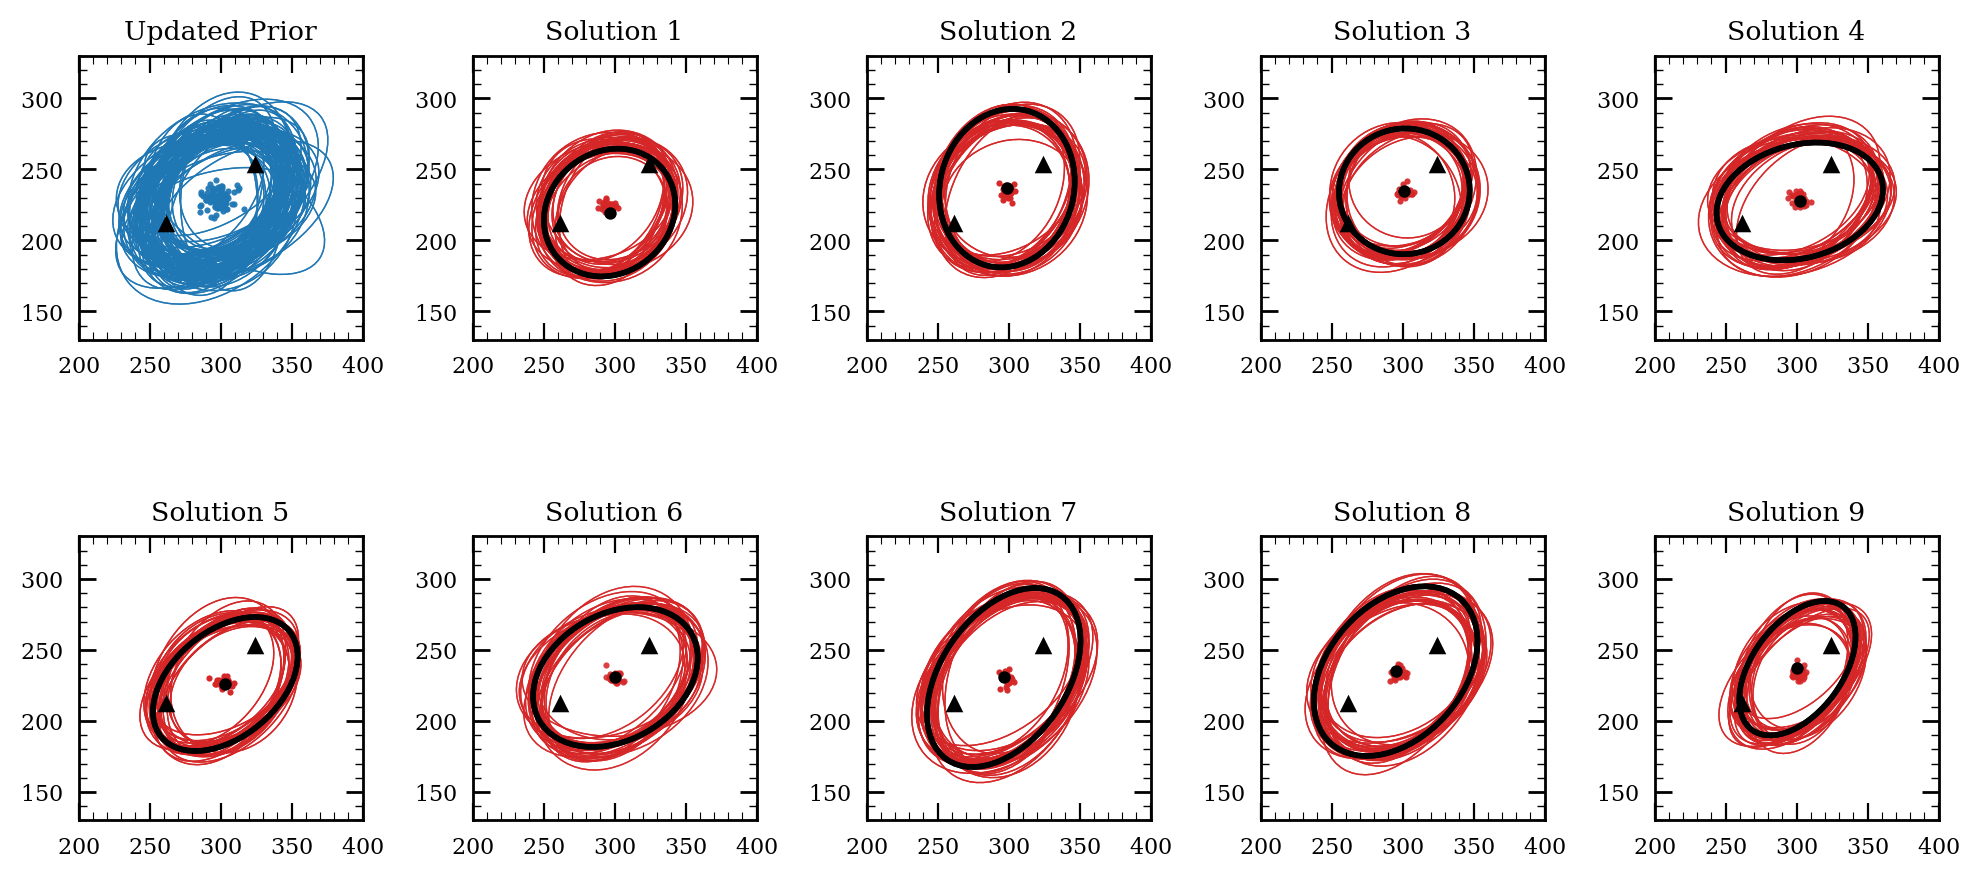

In [23]:
from helpers.plotting import plot_ellipses

# Sample 10 true solutions from the prior
torch.manual_seed(0)
true_solutions_updated = updated_prior.sample((10,)).squeeze(1)

# Plot the true solutions and posterior means in a 5x2 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5), dpi=200)

fig.set_facecolor('white')

for i, ax in enumerate(axes.flatten()):
    
    if i == 0:
        ax.set_title('Updated Prior')
    
        prior_samples = updated_prior.sample((100,)).squeeze(1)
        
        plot_ellipses(ax, prior_samples[:, :2], prior_samples[:, 2:4],
                        prior_samples[:, 5], prior_samples[:, 4],
                        scatter_kwargs={'c': 'tab:blue', 's': 5},
                        ellipse_kwargs={'edgecolor': 'tab:blue', 'linewidth': 0.5})
    else:
        ax.set_title(f'Solution {i}')
    
        observed_data = forward_model(
            true_solutions_updated[i].unsqueeze(0), updated_design.cpu()).squeeze(0)
        
        posterior = updated_cond_gaussian(
            observed_data.unsqueeze(0), updated_design.cpu().unsqueeze(0))
        
        posterior_samples = posterior.sample((30,)).squeeze(1)
        
        post_means = posterior_samples[..., :2]
        post_stds = posterior_samples[..., 2:4]
        post_amps = posterior_samples[..., 4]
        post_thetas = posterior_samples[..., 5]    
                
        plot_ellipses(ax, post_means, post_stds, post_thetas, post_amps,
                    scatter_kwargs={'c': 'tab:red', 's': 5},
                    ellipse_kwargs={'edgecolor': 'tab:red', 'linewidth': 0.5})
        
        plot_ellipses(
            ax,
            true_solutions_updated[i, :2].unsqueeze(0),
            true_solutions_updated[i, 2:4].unsqueeze(0),
            true_solutions_updated[i, 5].unsqueeze(0),
            true_solutions_updated[i, 4].unsqueeze(0),
            scatter_kwargs={'c': 'k', 's': 20},
            ellipse_kwargs={'edgecolor': 'k', 'linewidth': 2.0})
        
    ax.scatter(updated_design[:, 0], updated_design[:, 1], linewidths=0, marker='^', color='k', s=40)
    buffer = 100
    ax.set_xlim(
        true_model_mean[0, 0].item()-buffer,
        true_model_mean[0, 0].item()+buffer)
    
    ax.set_ylim(
        true_model_mean[0, 1].item()-buffer,
        true_model_mean[0, 1].item()+buffer)        
    
    # ax.set_xticks([])
    # ax.set_yticks([])
    
    ax.add_patch(plt.Rectangle((0, 0), length_x, length_y, fill=None, linestyle='dashed', color='black', linewidth=1))
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()